In [236]:
# Luminosity, Schechter function, etc. 

# Runtime error:

# Need to calculate E(z) only once, and re-use that vector for each calculation of Distance Modulus, rather than
# having the integrals nested.

# should also check for divide by zero, or numbers going above max double float size (-1.797e+308, 1.797e+308)
# 

# Imports
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt


[64.0, 128.0, 192.0]


In [130]:
# David Hogg Paper
EDS = np.array([1, 0, 0])
LD = np.array([0.05, 0, 0.95])
HL = np.array([0.2, 0.8, 0])

#Msci paper
# Omega M, Omega Lambda, Omega K
LCDM = np.array([0.3, 0.7, 0])
EDS = np.array([1, 0, 0])
OCDM = ([0.3, 0, 0.7])

# W0, W1
wBasic = np.array([-1, 0])
w8 = np.array([-0.8, 0])
w9 = np.array([-0.9, 0])
w11 = np.array([-1.1, 0])
w12 = np.array([-1.2, 0])

# Schecher parameters
# Phi1, Phi2, a1, a2, Mass*
# The Schechter parameters found  in the paper by Baldry, Driver, Loveday, Taylor et al. (2011)
CanonicalSchechter = np.array([3.96*10**-3, 0.79*10**-3, -0.35, -1.47, 10**10.66])

zArray = np.linspace(0.01, 5, num = 200)
MagArray = np.linspace(-30, 50, num = 200)

In [131]:
# Constants

c = 3 * 10**8
H_0 = 70
D_H = (c / H_0)
MSol = 1.99 * 10**30

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Part 1: Setting up distances and Distance Modulus

In [132]:
def Ez(z, OmeM, OmeCos, OmeK, w0, w1): #Doesn't switch equation automatically
    if OmeK > 0: # Is this distribution of equations true?
        return np.sqrt(OmeM * (1 + z)**3 + OmeK * (1 + z)**2 + OmeCos)
    elif OmeK == 0:
        return np.sqrt(OmeM * (1 + z)**3 + (1 - OmeM) * (1 + z)**(3 * (1 + w0 + w1)) * np.exp(-3 * w1 * z))

In [133]:
# Comoving distance for line-of-sight distance calculation

def ComDisLOS(z, OmeM, OmeCos, OmeK, w0, w1):
    integral = integrate.quad(lambda Z: 1/(Ez(Z, OmeM, OmeCos, OmeK, w0, w1)), 0, z) # integration holds error
    return integral[0]

ComDisLOSVec = np.vectorize(ComDisLOS, excluded=['ws'])

In [134]:
def ComDisTra(z, OmeM, OmeCos, OmeK, w0, w1):
    if OmeCos == 0:
        A = 2 - OmeM * (1-z)
        B = (2 - OmeM) * np.sqrt(1 + OmeM * z)
        C = OmeM**2 * (1 + z)
        distance = 2 * (A - B)/C
        return distance
        
    else:
        if OmeK > 0:
            distance = (1 / np.sqrt(OmeK)) * np.sinh(np.sqrt(OmeK) * ComDisLOS(z, OmeM, OmeCos, OmeK, w0, w1) )
        elif OmeK < 0:
            distance = (1 / np.sqrt(np.absolute(OmeK))) * np.sin(np.sqrt(np.absolute(OmeK)) * ComDisLOS(z, OmeM, OmeCos, OmeK, w0, w1) )
        elif OmeK == 0:
            distance = ComDisLOS(z, OmeM, OmeCos, OmeK, w0, w1)
    return distance

ComDisTraVec = np.vectorize(ComDisTra, excluded=['ws'])

In [135]:
# Luminosity distance

def LumDist(z, OmeM, OmeCos, OmeK, w0, w1):
    return (1 + z) * ComDisTra(z, OmeM, OmeCos, OmeK, w0, w1)

In [136]:
# Distance Modulus

def DistanceModulus(z, OmeM, OmeCos, OmeK, w0, w1):
    return 5 * np.log10(LumDist(z, OmeM, OmeCos, OmeK, w0, w1)*(D_H * 10**(-10)))
                        
DistModVec = np.vectorize(DistanceModulus)

In [279]:
# Angular diameter distance

def DiamDist(z, OmeM, OmeCos, OmeK, w0, w1):
    return (ComDisTra(z, OmeM, OmeCos, OmeK, w0, w1) / (1 + z))

DiamDistVec = np.vectorize(DiamDist, excluded=['ws'])


In [280]:
def ComVolEl(z, OmeM, OmeCos, OmeK, w0, w1):
    return (1 + z)**2 * DiamDist(z, OmeM, OmeCos, OmeK, w0, w1)**2 / Ez(z, OmeM, OmeCos, OmeK, w0, w1) # delta solid angle?

ComVolElVec = np.vectorize(ComVolEl, excluded=['ws'])

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Part 2: Double Schechter function; playing around and trying to get it to work

In [137]:
# magnitudes = np.linspace(5, 15, num = 200)

# def SchechterDiff(Phi, a, Mstar, M):
#     return Phi * np.log(10) * (10**(0.4*(Mstar - M)))**(a + 1) * np.exp(-10**(0.4*(Mstar-M)))

# #np.vectorize(SchechterDiff)

# def Schechter(Phi, a, Mstar, M):
#     integral = integrate.quad(lambda m: (SchechterDiff(Phi, a, Mstar, m)), 0, np.inf) # integration holds error
#     return integral[0]

# values = SchechterDiff(1.2 * 10**(-2), -0.25, 7, magnitudes)

# plt.plot(magnitudes, values)
# plt.show()

# SchechterVec = np.vectorize(Schechter)

In [200]:
# Schechter function for masses
# Double schechter function from paper by Baldry, Driver, Loveday, Taylor et al. (2011)

def DoubleSchechterDiff(Phi1, Phi2, a1, a2, MassStar, Mass): #in MASSES =(
    Density = np.exp(-Mass/MassStar) * (Phi1 * (Mass/MassStar)**a1 + Phi2 * (Mass/MassStar)**a2 ) #* (1/(MassStar))
    return Density


DoubleSchechterDiffVec = np.vectorize(DoubleSchechterDiff)

Checking that the function behaves as in the Baldry, Driver, Loveday, Taylor et al. (2011) paper for masses.

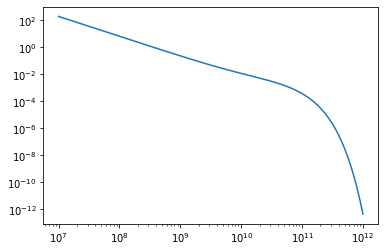

In [202]:
# masses = np.logspace((7 - 2 * np.log(H_0/70)), (12 - 2 * np.log(H_0/70)), num = 200)
# densities = DoubleSchechterDiffVec(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], \
#                                  CanonicalSchechter[3], CanonicalSchechter[4], masses)


# plt.plot(masses, densities)
# plt.yscale("Log")
# plt.xscale("Log")
# plt.show()

# Behaviour as in Baldry, Driver, Loveday, Taylor et al. (2011)
# But y axis is wrong. Density varies too quickly

In [198]:
# Luminosity from mass
# Currently just a stand-in function!!! Not even an approximation!!!!!!!!
# But this is what Dr. Conselice said to do in the supervision meeting; "just use luminosity *3 or something"

# Mass to light ratio depends on age of galaxy, type of galaxy, whether in a cluster etc.

def LumfromMass(mass):
    Lum = 5 * mass * Msol # units of solar mass
    return Lum
# Mass from luminosity
def MassFromLum(Lum):
    mass = Lum/(5 * MSol)
    return mass

In [140]:
# Absolute Magnitue from Luminosity
def MagnitudeFromLum(Lum):
    Mag = -2.5*np.log10(Lum/3.0128*10**28)
    return Mag
# Luminosity from absolute magnitude
def LumFromMagnitude(Mag):
    Lum = 10**(-Mag/2.5) * 3.0128*10**28
    return Lum

In [141]:
# magnitude from Absolute Magnitude
# m = M + DM + K
def MagFromAbsMag(Mag, DM, K):
    mag = Mag + DM + K
    return mag

def AbsMagFromMag(mag, DM, K):
    Mag = mag - DM - K
    return Mag


In [142]:
# Schechter function as a distribution of magnitudes 
# 
def SchechterMagnitudes(Phi1, Phi2, a1, a2, MassStar, mag, DM, K):
    Density = DoubleSchechterDiffVec(Phi1, Phi2, a1, a2, MassStar, MassFromLum(LumFromMagnitude(AbsMagFromMag(mag, DM, K))))
    return Density

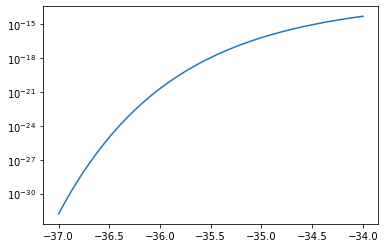

In [199]:

MagnitudesDistrib = SchechterMagnitudes(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], MagArray, 0, 0)

MagArray = np.linspace(-37, -34, num = 200)

plt.plot(MagArray, MagnitudesDistrib)
plt.yscale("Log")
plt.show()


Now I wanted to check what was going on each step of the way, so I test the behaviour of a set of magnitudes as they go through each function.

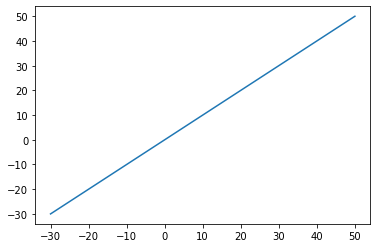

In [144]:

# AbsoluteMagnitudes = AbsMagFromMag(MagArray, 0, 0)

# plt.plot(MagArray, AbsoluteMagnitudes)
# plt.show()

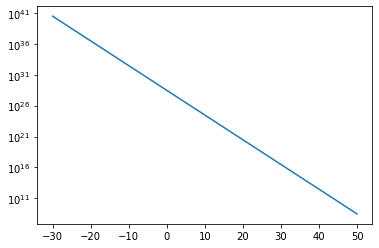

In [164]:
# Luminosities = LumFromMagnitude(AbsoluteMagnitudes)

# plt.plot(MagArray, Luminosities)
# plt.yscale("Log")
# plt.show()

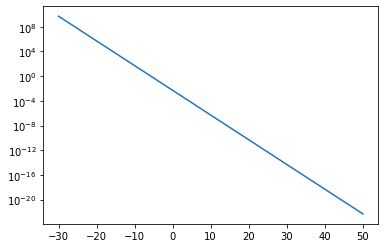

In [165]:
# Masses = MassFromLum(Luminosities)
# plt.plot(MagArray, Masses)
# plt.yscale("Log")
# plt.show()

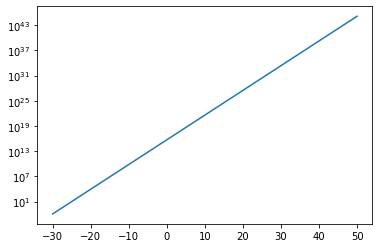

In [163]:
# Schechter distribution of magnitudes

# Not showing expected behaviour!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Density = DoubleSchechterDiffVec(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], \
#                                  CanonicalSchechter[3], CanonicalSchechter[4], MassFromLum(LumFromMagnitude(
#     AbsMagFromMag(MagArray, DistanceModulus(0.5, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1]), 0))))

# plt.plot(MagArray, Density)
# plt.yscale("Log")
# plt.show()

# Should be curve

From here I'm trying to integrate the double schecter function, but I haven't found a method that works. 

In [159]:
def DensityAtZ(Phi1, Phi2, a1, a2, MassStar, z, OmeM, OmeCos, OmeK, w0, w1):
    integral = integrate.quad(lambda M: DoubleSchechterDiffVec(Phi1, Phi2, a1, a2, MassStar, MassFromLum(LumFromMagnitude
                        (AbsMagFromMag(M, DistanceModulus(z, OmeM, OmeCos, OmeK, w0, w1), 0)))), -np.inf, 25)
    return integral[0]

In [ ]:
test = np.array([1,2,3])

def func(a, b, c):
    return c * a ** b
    

UpTo25 = [(integrate.quad(lambda A: (func(A, 3, i)) , 0, 4)[0]) for i in test]

print(UpTo25)

In [264]:

# def SchechterFromMag(mag, Phi1, Phi2, a1, a2, MassStar):
#     return np.exp(-(10**(-(mag)/2.5) * 3.0128*10**28)/MassStar) * (Phi1 * ((10**(-(mag)/2.5) * 3.0128*10**28)/MassStar)**a1 + Phi2 * ((10**(-(mag)/2.5) * 3.0128*10**28)/MassStar)**a2 )


# def DensityAtZ(Phi1, Phi2, a1, a2, MassStar, z, OmeM, OmeCos, OmeK, w0, w1):
#     Line_Of_Sight = ComDisLOSVec(z, OmeM, OmeCos, OmeK, w0, w1)
    
#     # 
#     if OmeCos == 0:
#         A = 2 - OmeM * (1-z)
#         B = (2 - OmeM) * np.sqrt(1 + OmeM * z)
#         C = OmeM**2 * (1 + z)
#         Transverse = 2 * (A - B)/C
        
#     else:
#         if OmeK > 0:
#             Transverse = (1 / np.sqrt(OmeK)) * np.sinh(np.sqrt(OmeK) * Line_Of_Sight )
#         elif OmeK < 0:
#             Transverse = (1 / np.sqrt(np.absolute(OmeK))) * np.sin(np.sqrt(np.absolute(OmeK)) * Line_Of_Sight )
#         elif OmeK == 0:
#             Transverse = Line_Of_Sight
    
#     LuminosityDist = (1 + z) * Transverse
    
#     DistModulus = 5 * np.log10(LuminosityDist)
    
#     KCorrection = 0
    
#     # Matrix of all possible magnitude input and all possible distance-modulus input?
#     # But this needs to be a function that can be integrated up to the desired apparent magnitude.
    
#     #UpTo25 = np.ones(len(DistanceModulus))
    
#     print(DistModulus)
    
#     UpTo25 = [(integrate.quad(lambda M: (SchechterFromAbsMag(M, CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4])) , -35, (25-i))[0]) for i in DistanceModulus]
    
#     print(UpTo25)
    
#     return UpTo25
# #     AbsMagnitude = apparentmagnitude - DistModulus - KCorrection
    
# #     Luminosity = 10**(-AbsMagnitude/2.5) * 3.0128*10**28
    
# #     # Schechter Function
# #     Density = np.exp(-Mass/MassStar) * (Phi1 * (Mass/MassStar)**a1 + Phi2 * (Mass/MassStar)**a2 ) * (1/(MassStar * MSol))





    

In [266]:
# print(DensityAtZ(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], 
#  np.array([0.5, 2, 3, 4, 5]), LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1]))

# One value of density at a disance z = 0.5 gives a runtime error. Must resolve this as need to calculate full spectrum
# of different z values.

# Also; 1.9 * 10^30 seems unnecessarily big? But this may also be because of the units of different quantities going
# into functions; as the luminosity to mass function is very much just a dummy function at the moment, haven't
# concentrated too much on units, concentrated on behaviour instead.


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Part 3: Going back to the single schechter function

(1.0848358990232265, 8.292988248025962e-10)


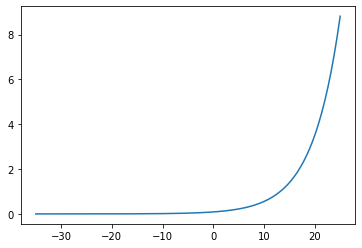

In [267]:
def SingleSchechter(Phi, alph, MStar, M):
    a = (2/5)*(MStar - M)
    return (2/5) * Phi * np.log(10) * (10**(a * (alph + 1))) * np.exp(-10**a)

Phi = 0.002
alph = -1.2
MStar = -21

test = integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, 4.5)
print(test)

magnitudes = np.linspace(-35, 25, num= 200)
distrib = SingleSchechter(Phi, alph, MStar, magnitudes)

plt.plot(magnitudes, distrib)
plt.show()

(47.85136693513732, 3.552866165338662e-07)


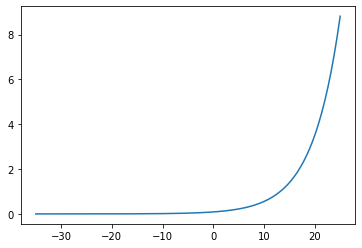

In [268]:
def SingleSchechter(Phi, alph, MStar, M):
    a = (2/5)*(MStar - M)
    return (2/5) * Phi * np.log(10) * (10**(a * (alph + 1))) * np.exp(-10**a)

Phi = 0.002
alph = -1.2
MStar = -21

test = integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, 25)
print(test)

magnitudes = np.linspace(-35, 25, num= 200)
distrib = SingleSchechter(Phi, alph, MStar, magnitudes)

plt.plot(magnitudes, distrib)
plt.show()

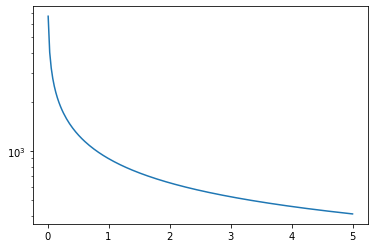

In [263]:
Zs = np.linspace(0.01, 5, num = 200)

DMs = DistModVec(Zs, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])

#print(DMs)
# How far is aboslute magnitude supposed to be? seems like DM always makes things brighter,
# no matter how far away they are
#m = M + DM + K

test = integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, (25 - DMs[0]))
#print(test)

test = [integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, (25 - i))[0] for i in DMs]
#print(test)

plt.plot(Zs, test)
plt.yscale("Log")
plt.show()

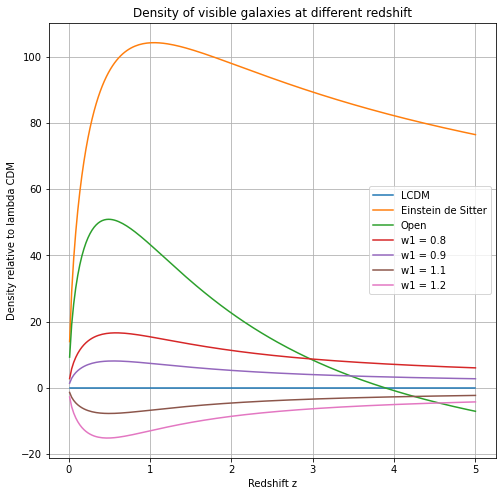

In [277]:
Zs = np.linspace(0.01, 5, num = 200)

def PlotVisibleDensity(Cosmology, Ws, z, Cosmoname):
    DMsL = DistModVec(z, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])
    DMsCos = DistModVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])
    
    Lambda = np.array([integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, (25 - i))[0] for i in DMsL])
    Cosmo = np.array([integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, (25 - i))[0] for i in DMsCos])
    
    Diff = np.subtract(Cosmo, Lambda)
    
    plt.plot(z, Diff, label = Cosmoname)
    #plt.yscale("Log")
    
def Roundoff(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend()
    
    plt.show()
    
   
plt.figure(figsize=(8,8))

PlotVisibleDensity(LCDM, wBasic, Zs, "LCDM")
PlotVisibleDensity(EDS, wBasic, Zs, "Einstein de Sitter")
PlotVisibleDensity(OCDM, wBasic, Zs, "Open")

PlotVisibleDensity(LCDM, w8, Zs, "w1 = 0.8")
PlotVisibleDensity(LCDM, w9, Zs, "w1 = 0.9")
PlotVisibleDensity(LCDM, w11, Zs, "w1 = 1.1")
PlotVisibleDensity(LCDM, w12, Zs, "w1 = 1.2")


Roundoff("Density of visible galaxies at different redshift", "Redshift z", "Density relative to lambda CDM")

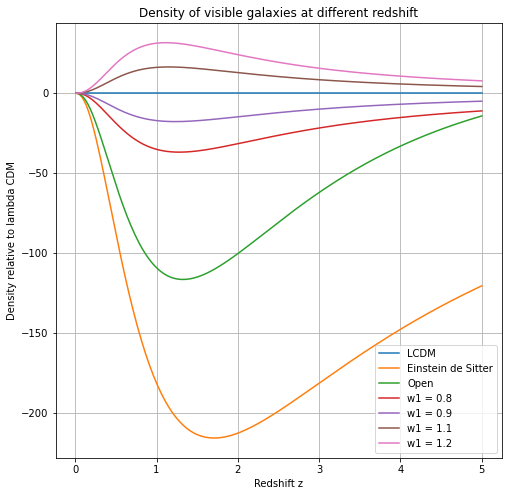

In [284]:
Zs = np.linspace(0.01, 5, num = 200)

def PlotVisibleDensity(Cosmology, Ws, z, Cosmoname):
    DMsL = DistModVec(z, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])
    DMsCos = DistModVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])
    
    Lambda = np.array([integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, (25 - i))[0] for i in DMsL])
    Cosmo = np.array([integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, (25 - i))[0] for i in DMsCos])
    
    Lambda = np.prod([Lambda, ComVolElVec(z, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])], axis = 0)
    Cosmo = np.prod([Cosmo, ComVolElVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])], axis = 0)
    
    Diff = np.subtract(Cosmo, Lambda)
    
    plt.plot(z, Diff, label = Cosmoname)
    #plt.yscale("Log")
    
def Roundoff(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend()
    
    plt.show()
    
   
plt.figure(figsize=(8,8))

PlotVisibleDensity(LCDM, wBasic, Zs, "LCDM")
PlotVisibleDensity(EDS, wBasic, Zs, "Einstein de Sitter")
PlotVisibleDensity(OCDM, wBasic, Zs, "Open")

PlotVisibleDensity(LCDM, w8, Zs, "w1 = 0.8")
PlotVisibleDensity(LCDM, w9, Zs, "w1 = 0.9")
PlotVisibleDensity(LCDM, w11, Zs, "w1 = 1.1")
PlotVisibleDensity(LCDM, w12, Zs, "w1 = 1.2")


Roundoff("Density of visible galaxies at different redshift", "Redshift z", "Density relative to lambda CDM")

Back to Double Schechter...

(6.901566234612882e+30, 2.8742675312708118e+17)


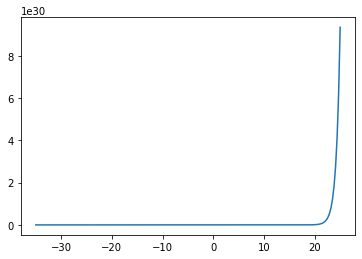

In [290]:
def SingleSchechter(Phi, alph, MStar, M):
    a = (2/5)*(MStar - M)
    return (2/5) * Phi * np.log(10) * (10**(a * (alph + 1))) * np.exp(-10**a)

def DoubleSchechter(Phi1, Phi2, a1, a2, MassStar, Magnitude): #in MASSES =(
    Density = np.exp(-MassFromLum(LumFromMagnitude(Magnitude))/MassStar) * (Phi1 * (MassFromLum(LumFromMagnitude(Magnitude))/MassStar)**a1 + Phi2 * (MassFromLum(LumFromMagnitude(Magnitude))/MassStar)**a2 )
    return Density

DoubleSchechterVec = np.vectorize(DoubleSchechter)

Phi1 = 3.96*10**-3
Phi2 = 0.79*10**-3
a1 = -0.35
a2 = -1.47
MStar = 10**10.66


test = integrate.quad(lambda x: DoubleSchechter(Phi1, Phi2, a1, a2, MStar, x), -35, 25)
print(test)

magnitudes = np.linspace(-35, 25, num= 200)
distrib = DoubleSchechterVec(Phi1, Phi2, a1, a2, MStar, magnitudes)

plt.plot(magnitudes, distrib)
plt.show()

(4.0829760274428036e+46, 9.643325360863934e+36)
[4.08297603e+46 9.65307166e+44 1.87439211e+44 6.39179522e+43
 2.84955968e+43 1.48742041e+43 8.61744204e+42 5.37743910e+42
 3.54783578e+42 2.44457869e+42 1.74411827e+42 1.28050027e+42
 9.62926101e+41 7.39027215e+41 5.77243738e+41 4.57835815e+41
 3.68056594e+41 2.99443904e+41 2.46242092e+41 2.04451522e+41
 1.71239237e+41 1.44563978e+41 1.22932045e+41 1.05234990e+41
 9.06396885e+40 7.85125897e+40 6.83667093e+40 5.98239955e+40
 5.25882594e+40 4.64254653e+40 4.11492174e+40 3.66099604e+40
 3.26868646e+40 2.92816728e+40 2.63139945e+40 2.37176779e+40
 2.14379922e+40 1.94294230e+40 1.76539361e+40 1.60796014e+40
 1.46794964e+40 1.34308254e+40 1.23142113e+40 1.13131201e+40
 1.04133927e+40 9.60286247e+39 8.87103992e+39 8.20885313e+39
 7.60843238e+39 7.06293098e+39 6.56637568e+39 6.11354124e+39
 5.69984498e+39 5.32125780e+39 4.97422879e+39 4.65562131e+39
 4.36265846e+39 4.09287652e+39 3.84408517e+39 3.61433318e+39
 3.40187894e+39 3.20516508e+39 3.0227

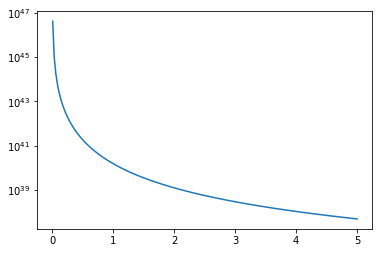

In [292]:
Zs = np.linspace(0.01, 5, num = 200)

DMs = DistModVec(Zs, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])

#print(DMs)
# How far is aboslute magnitude supposed to be? seems like DM always makes things brighter,
# no matter how far away they are
#m = M + DM + K

test = integrate.quad(lambda x: DoubleSchechter(Phi1, Phi2, a1, a2, MStar, x), -35, (25 - DMs[0]))
#print(test)

test = np.array([integrate.quad(lambda x: DoubleSchechter(Phi1, Phi2, a1, a2, MStar, x), -35, (25 - i))[0] for i in DMs])
#print(test)
#Far too big!!! Numbers are huge.

plt.plot(Zs, test)
plt.yscale("Log")
plt.show()

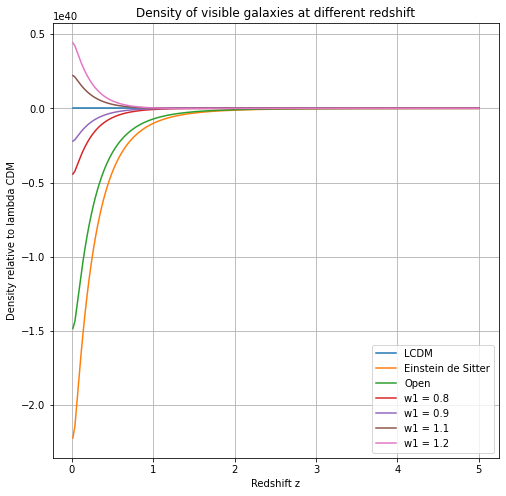

In [293]:
Zs = np.linspace(0.01, 5, num = 200)

def PlotVisibleDensity(Cosmology, Ws, z, Cosmoname):
    DMsL = DistModVec(z, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])
    DMsCos = DistModVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])
    
    Lambda = np.array([integrate.quad(lambda x: DoubleSchechter(Phi1, Phi2, a1, a2, MStar, x), -35, (25 - i))[0] for i in DMsL])
    Cosmo = np.array([integrate.quad(lambda x: DoubleSchechter(Phi1, Phi2, a1, a2, MStar, x), -35, (25 - i))[0] for i in DMsCos])
    
    Lambda = np.prod([Lambda, ComVolElVec(z, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])], axis = 0)
    Cosmo = np.prod([Cosmo, ComVolElVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])], axis = 0)
    
    Diff = np.subtract(Cosmo, Lambda)
    
    plt.plot(z, Diff, label = Cosmoname)
    #plt.yscale("Log")
    
def Roundoff(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend()
    
    plt.show()
    
   
plt.figure(figsize=(8,8))

PlotVisibleDensity(LCDM, wBasic, Zs, "LCDM")
PlotVisibleDensity(EDS, wBasic, Zs, "Einstein de Sitter")
PlotVisibleDensity(OCDM, wBasic, Zs, "Open")

PlotVisibleDensity(LCDM, w8, Zs, "w1 = 0.8")
PlotVisibleDensity(LCDM, w9, Zs, "w1 = 0.9")
PlotVisibleDensity(LCDM, w11, Zs, "w1 = 1.1")
PlotVisibleDensity(LCDM, w12, Zs, "w1 = 1.2")


Roundoff("Density of visible galaxies at different redshift", "Redshift z", "Density relative to lambda CDM")